In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.set_printoptions(sci_mode=False, precision=4)

%matplotlib inline

In [13]:
words = open('names.txt', 'r').read().splitlines()
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

In [14]:
chars = ''.join(sorted(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(stoi)

In [156]:
block_size = 8  # context length: how many characters to look back

def build_ds(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)

            # print(''.join(itos[i] for i in context), '->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n = len(words)
n1 = int(n * 0.8)
n2 = int(n * 0.9)

Xtr, Ytr = build_ds(words[:n1])
Xdev, Ydev = build_ds(words[n1:n2])
Xte, Yte = build_ds(words[n2:])


In [201]:
class  Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])


class Tanh():
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

class Flatten(nn.Module):
    def __init__(self, n):
        super(Flatten, self).__init__() 
        self.n = n

    def __call__(self, x):
        # print(x.shape)
        B, T, C = x.shape
        if T == self.n:
            return  x.view(B, C * self.n)
        return x.view(B, T//2, C * self.n)
        out =  x.view(B, -1, C * self.n)
        print(out.shape)
        return out


    def parameters(self):
        return []
    

In [247]:
n_embd = 24
n_hidden = 128
batch_size = 128
# C = torch.randn((vocab_size, n_embd))
model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    Flatten(2), nn.Linear(n_embd * 2, n_embd * 2), nn.Tanh(),
    Flatten(2), nn.Linear(n_embd * 4, n_embd * 4), nn.Tanh(),
    Flatten(2), nn.Linear(n_embd * 8, n_hidden), nn.Tanh(),
    nn.Flatten(start_dim=1),
    nn.Linear(           n_hidden, vocab_size)
)


parameters = list(model.parameters())
print(sum(p.numel() for p in parameters))

print(model)

40499
Sequential(
  (0): Embedding(27, 24)
  (1): Flatten()
  (2): Linear(in_features=48, out_features=48, bias=True)
  (3): Tanh()
  (4): Flatten()
  (5): Linear(in_features=96, out_features=96, bias=True)
  (6): Tanh()
  (7): Flatten()
  (8): Linear(in_features=192, out_features=128, bias=True)
  (9): Tanh()
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=128, out_features=27, bias=True)
)


In [203]:
ix = torch.randint(0, Xtr.shape[0], (2, ))
model(Xtr[ix])

tensor([[-0.0853, -0.0411, -0.0375,  0.0556, -0.0923, -0.0358,  0.1227,  0.1058,
         -0.0311,  0.1024, -0.2277, -0.0481, -0.1297, -0.0074, -0.0793, -0.0666,
          0.0420,  0.0480,  0.0123,  0.0788,  0.0470,  0.0553, -0.0716, -0.0446,
         -0.0663,  0.0776, -0.0012],
        [-0.0853, -0.0411, -0.0375,  0.0556, -0.0923, -0.0358,  0.1227,  0.1058,
         -0.0311,  0.1024, -0.2277, -0.0481, -0.1297, -0.0074, -0.0793, -0.0666,
          0.0420,  0.0480,  0.0123,  0.0788,  0.0470,  0.0553, -0.0716, -0.0446,
         -0.0663,  0.0776, -0.0012]], grad_fn=<AddmmBackward0>)

In [248]:
n_embd = 24
n_hidden = 200
batch_size = 128
# C = torch.randn((vocab_size, n_embd))
model = nn.Sequential(
    nn.Embedding(vocab_size, n_embd),
    nn.Flatten(start_dim=1),
    nn.Linear(n_embd * block_size, n_hidden), nn.Tanh(),
    nn.Linear(           n_hidden, vocab_size)
)

parameters = list(model.parameters())
print(sum(p.numel() for p in parameters))


44675


In [249]:
lossi = []
for i in range(100000):
    ix = torch.randint(0, Xtr.shape[0], (128, ))
    xb = Xtr[ix]
    yb = Ytr[ix]
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)
    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 20000 else 0.03
    # lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    if i % 5000 == 0:
        dl = F.cross_entropy(model(Xdev), Ydev).item()
        tl = F.cross_entropy(model(Xte), Yte).item()
        print(f'{i:7d}, {loss.item():8.5f}, test: {dl:8.5f}, train: {tl:8.5f}')
        # print(loss.item(), i)
    # if i > 10: break
    # ud.append([(lr * p.grad.std() / p.std()).log10().item() for p in parameters])
    lossi.append(loss.item())
    if i > 40000: break
    # break

      0,  3.31239, test:  3.21109, train:  3.21505
   5000,  2.32259, test:  2.14832, train:  2.15089
  10000,  1.75707, test:  2.10637, train:  2.10647
  15000,  2.06631, test:  2.07497, train:  2.07796
  20000,  1.85434, test:  2.05721, train:  2.06393
  25000,  1.94458, test:  2.02810, train:  2.03446
  30000,  1.80108, test:  2.02372, train:  2.03297
  35000,  1.65935, test:  2.02575, train:  2.03449
  40000,  1.72901, test:  2.02635, train:  2.03464


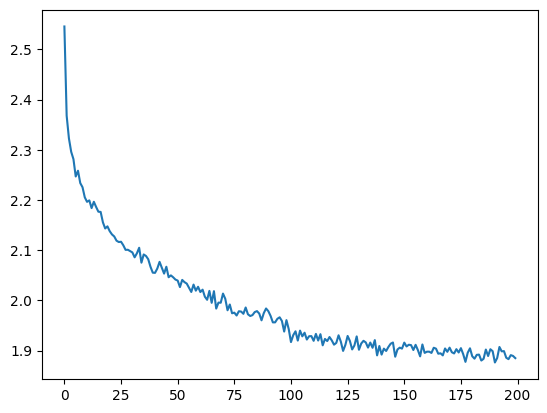

In [257]:
plt.plot(torch.tensor(lossi[:40000]).view(-1, 200).mean(1))

# torch.tensor(lossi[:4000]).view(-1, 200).mean(1)
# lossi[-100:]

In [171]:
torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)

tensor([[[-1.4075, -0.6745,  2.0021,  0.4598, -1.0982, -0.0577,  0.7311,
          -1.5904,  0.6844,  0.3090, -0.7549, -1.2167, -0.8565,  0.5521,
          -1.4030, -0.3761],
         [ 0.5611,  1.5897,  2.5497,  0.4443, -1.2002, -0.9383, -0.7329,
           0.1203,  0.2304,  0.0789, -1.3712,  1.0214, -0.4485, -0.9589,
          -0.5496,  2.1487]],

        [[ 1.7545, -0.0479, -0.6718, -1.3892,  0.7379,  0.9744,  0.1154,
           3.5711, -1.8919,  0.8828, -0.5519, -0.2317, -2.3965,  0.7547,
           0.3839, -1.2203],
         [ 0.3023, -2.1313, -0.1028, -1.0906, -1.6187,  0.2417, -0.7234,
           0.4161,  0.8959, -1.6365, -0.9594, -0.8403, -0.0186,  0.7967,
           0.7722, -1.9648]]])

In [172]:
e.view(2, 2, -1)

tensor([[[-1.4075, -0.6745,  2.0021,  0.4598, -1.0982, -0.0577,  0.7311,
          -1.5904,  0.6844,  0.3090, -0.7549, -1.2167, -0.8565,  0.5521,
          -1.4030, -0.3761],
         [ 0.5611,  1.5897,  2.5497,  0.4443, -1.2002, -0.9383, -0.7329,
           0.1203,  0.2304,  0.0789, -1.3712,  1.0214, -0.4485, -0.9589,
          -0.5496,  2.1487]],

        [[ 1.7545, -0.0479, -0.6718, -1.3892,  0.7379,  0.9744,  0.1154,
           3.5711, -1.8919,  0.8828, -0.5519, -0.2317, -2.3965,  0.7547,
           0.3839, -1.2203],
         [ 0.3023, -2.1313, -0.1028, -1.0906, -1.6187,  0.2417, -0.7234,
           0.4161,  0.8959, -1.6365, -0.9594, -0.8403, -0.0186,  0.7967,
           0.7722, -1.9648]]])

In [242]:
ud = []
from torch.optim import AdamW

#   25000,  1.69626, test:  2.02098, train:  2.03392
#   25000,  1.98112, test:  2.01002, train:  2.01222



optimizer = AdamW(parameters, 0.00005)
# optimizer = AdamW(parameters, 0.001)

for i in range(100000):
    ix = torch.randint(0, Xtr.shape[0], (128, ))
    xb = Xtr[ix]
    yb = Ytr[ix]
    logits = model(xb)
    loss = F.cross_entropy(logits, yb)
    # loss = call_model(xb, yb)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % 5000 == 0:
        dl = F.cross_entropy(model(Xdev), Ydev).item()
        tl = F.cross_entropy(model(Xte), Yte).item()
        print(f'{i:7d}, {loss.item():8.5f}, test: {dl:8.5f}, train: {tl:8.5f}')
    # ud.append([(lr * p.grad.std() / p.std()).log10().item() for p in parameters])
    if i > 40000: break
    # break

      0,  1.86437, test:  2.02796, train:  2.03625
   5000,  1.91586, test:  1.99932, train:  2.00547
  10000,  1.68982, test:  1.99592, train:  2.00272
  15000,  2.03174, test:  1.99521, train:  2.00174
  20000,  2.18383, test:  1.99569, train:  2.00225
  25000,  2.03106, test:  1.99588, train:  2.00190
  30000,  1.98890, test:  1.99591, train:  2.00272
  35000,  1.80695, test:  1.99638, train:  2.00306
  40000,  1.76383, test:  1.99633, train:  2.00179


In [244]:
for _ in range(10):
    context = [0] * block_size
    out = []
    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True)
        ix = ix.item()
        if ix == 0:
            break

        out.append(ix)
        context = context[1:] + [ix]
    print(''.join(itos[i] for i in out))

grayson
xiliana
naddovie
meylah
verenina
mayonie
alexa
chinley
abien
ahliyah


In [116]:
embs = torch.nn.Embedding(vocab_size, n_embd)

f = torch.nn.Flatten(start_dim=1)

x = torch.tensor([[1, 2, 3], [1, 2, 3]])

emb = embs.weight[x]
emb

f(embs(x)), emb




(tensor([[ 1.1223,  2.2266, -0.1567, -0.5323, -0.9445, -0.7808, -0.9955,  0.0873,
           0.7515, -0.5353, -0.5558,  0.3095,  0.8466,  1.3339,  0.7712, -2.4661,
           0.1125, -2.7191, -1.9606, -2.3728, -0.6955,  0.7626,  0.6915, -1.3316,
          -0.2065, -0.3901, -0.6065, -0.9749, -1.5510,  0.9521, -1.0539, -0.4336,
           0.5424,  0.1486, -0.4326,  2.1067,  0.1458, -1.3713,  1.5570,  0.9331,
           0.9038, -2.2685,  1.0413,  0.8165,  1.8748, -1.2102, -0.4509, -0.2984],
         [ 1.1223,  2.2266, -0.1567, -0.5323, -0.9445, -0.7808, -0.9955,  0.0873,
           0.7515, -0.5353, -0.5558,  0.3095,  0.8466,  1.3339,  0.7712, -2.4661,
           0.1125, -2.7191, -1.9606, -2.3728, -0.6955,  0.7626,  0.6915, -1.3316,
          -0.2065, -0.3901, -0.6065, -0.9749, -1.5510,  0.9521, -1.0539, -0.4336,
           0.5424,  0.1486, -0.4326,  2.1067,  0.1458, -1.3713,  1.5570,  0.9331,
           0.9038, -2.2685,  1.0413,  0.8165,  1.8748, -1.2102, -0.4509, -0.2984]],
        grad_

In [115]:
emb.shape
torch.flatten(emb, start_dim=1)

t = torch.nn.Flatten(start_dim=1)
t(emb)

tensor([[-0.6362,  1.5533, -1.2454, -0.0473, -1.2544, -1.2227, -0.3731, -1.5391,
         -0.0476, -1.3528,  0.5531,  0.1787, -0.8575,  2.9188,  0.7895,  3.2096,
         -0.5261, -2.9601,  2.1140, -1.4822, -0.0194, -0.5918, -1.0075,  1.1531,
          0.7110, -0.4934, -0.0518,  1.5655, -1.3935,  0.6193,  1.3038, -0.9097,
          0.1655, -0.0335, -1.0422,  0.3588,  1.7566,  0.2014,  1.2237, -0.2169,
         -3.4729,  0.1846,  1.3110, -1.3502,  0.4453, -0.4934, -2.4068, -1.6707],
        [-0.6362,  1.5533, -1.2454, -0.0473, -1.2544, -1.2227, -0.3731, -1.5391,
         -0.0476, -1.3528,  0.5531,  0.1787, -0.8575,  2.9188,  0.7895,  3.2096,
         -0.5261, -2.9601,  2.1140, -1.4822, -0.0194, -0.5918, -1.0075,  1.1531,
          0.7110, -0.4934, -0.0518,  1.5655, -1.3935,  0.6193,  1.3038, -0.9097,
          0.1655, -0.0335, -1.0422,  0.3588,  1.7566,  0.2014,  1.2237, -0.2169,
         -3.4729,  0.1846,  1.3110, -1.3502,  0.4453, -0.4934, -2.4068, -1.6707]],
       grad_fn=<ViewBackw